# 🎬 IMDb Sentiment Analysis with Transformers

This project evaluates the performance of a pre-trained transformer-based sentiment classification model on IMDb movie reviews. By leveraging Hugging Face’s `transformers` library, we aim to determine whether such models can effectively capture positive and negative sentiment in real-world review texts.


<details>
<summary><strong> Set-up Environment for Hugging Face Transformers</strong></summary>


In [45]:
!pip install datasets
!pip install transformers
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


<details>
<summary><strong>📊 Load IMDb Dataset</strong></summary>

In this section, we load the IMDb movie review dataset using the `datasets` library from Hugging Face and convert it into a Pandas DataFrame for easier manipulation and visualization.

In [63]:
from datasets import load_dataset
import pandas as pd

# Load the IMDb dataset
dataset = load_dataset("imdb")
train_data = dataset["train"]

# Convert to DataFrame
df = pd.DataFrame(train_data)

<details>
<summary><strong>📊Explore Basic Distributions</strong></summary>

We perform two types of exploratory data analysis (EDA):

### 1. Sentiment Label Distribution
We count the number of positive and negative reviews and plot the distribution as a bar chart. This helps us determine whether the dataset is balanced or skewed toward one sentiment class.

- `sentiment = 0` → Negative
- `sentiment = 1` → Positive

### 2. Review Length Distribution
We calculate the number of words in each review by splitting on spaces (`len(x.split())`). Then, we display the histogram of review lengths to observe the range and common length of user reviews.

This gives us an idea of text variability, which is important for model input processing.

</details>

sentiment
0    12500
1    12500
Name: count, dtype: int64


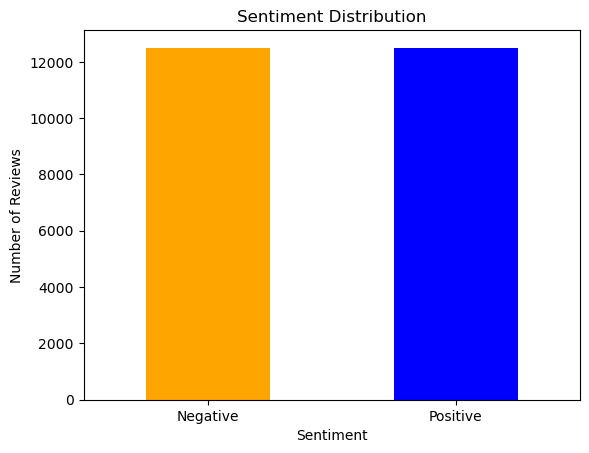

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: length, dtype: float64


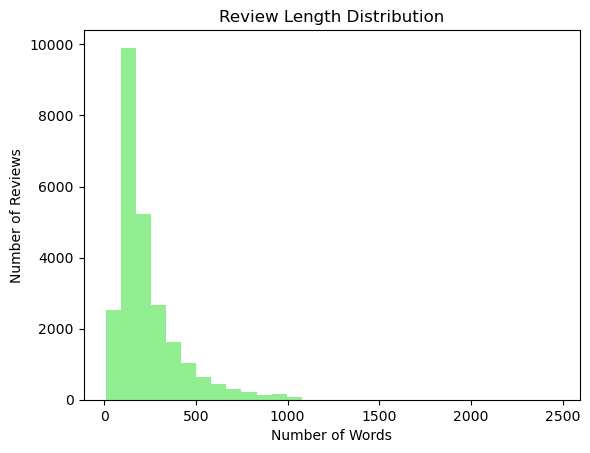

In [55]:
import matplotlib.pyplot as plt

# Rename columns for consistency
df = df.rename(columns={"text": "review", "label": "sentiment"})

# Sentiment distribution
print(df["sentiment"].value_counts())
df["sentiment"].value_counts().plot(kind='bar', color=['orange', 'blue'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.show()

# Review length distribution
df["length"] = df["review"].apply(lambda x: len(x.split()))
print(df["length"].describe())
plt.hist(df["length"], bins=30, color='lightgreen')
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Positive reviews: Combine into one string
positive_text = " ".join(df[df["sentiment"] == 1]["review"])

# Negative reviews: Combine into one string
negative_text = " ".join(df[df["sentiment"] == 0]["review"])


### 📦 Load Pre-trained Sentiment Model

We use Hugging Face’s `pipeline` to load a pre-trained DistilBERT model fine-tuned on SST-2 for binary sentiment classification.  
A quick test shows it correctly identifies positive sentiment in a sample sentence.

In [56]:
from transformers import pipeline

# Load the sentiment analysis model (from Hugging Face)
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
result = classifier("This movie was absolutely wonderful!")
print(result)


Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998792409896851}]


<details>
<summary><strong>🤖 Run Predictions with Hugging Face Classifier</strong></summary>

In this step, we randomly select 100 reviews from the IMDb dataset to evaluate how well the pre-trained sentiment classifier performs.

### 🔍 What happens here:

1. **Sample Selection**  
   We use `df.sample(n=100)` to randomly select 100 reviews for testing.  
   Setting `random_state=42` ensures reproducibility.

2. **Sentiment Prediction**  
   For each review:
   - We truncate the text to 512 tokens (to fit the BERT input limit).
   - The `classifier()` returns a sentiment label: `"POSITIVE"` or `"NEGATIVE"`.
   - We convert it to numerical format: `1` for positive, `0` for negative.

3. **Store Predictions**  
   The predicted values are stored in a list and added to the DataFrame as a new column called `"predicted_sentiment"`.

This prepares the data for downstream evaluation, such as computing accuracy or confusion matrix.
</details>

In [49]:
from sklearn.metrics import accuracy_score

# Randomly pick 100 pieces of data
sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)

# Save the model prediction results
predicted = []

for text in sample_df["review"]:
    result = classifier(text[:512])[0]  
    pred = 1 if result["label"] == "POSITIVE" else 0
    predicted.append(pred)

# Add prediction column
sample_df["predicted_sentiment"] = predicted

### 📈 Evaluate Model Performance

We calculate accuracy on 100 sampled reviews and print a classification report.  
A confusion matrix heatmap is also plotted to visualize prediction errors.


In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Calculate accuracy
acc = accuracy_score(sample_df["sentiment"], sample_df["predicted_sentiment"])
print(f"Accuracy on 100 reviews: {acc:.2%}")

#Output classification report
print(classification_report(sample_df["sentiment"], sample_df["predicted_sentiment"]))

Accuracy on 100 reviews: 78.00%
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        47
           1       0.88      0.68      0.77        53

    accuracy                           0.78       100
   macro avg       0.79      0.79      0.78       100
weighted avg       0.80      0.78      0.78       100



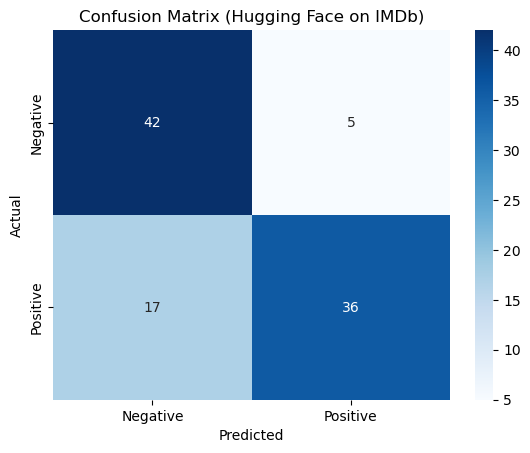

In [44]:
cm = confusion_matrix(sample_df["sentiment"], sample_df["predicted_sentiment"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Hugging Face on IMDb)")
plt.show()